## Imports

In [ ]:
import optax
import imageio
import numpy as np
import functools
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from jax import random
from jax.experimental import ode
from flax.training import train_state
from sklearn.datasets import make_moons
from scipy.integrate import solve_ivp

## Diffusion Model

In [ ]:
class Diffusion:
  def __init__(self, num_steps = 1000):
    self.num_steps = num_steps
    self.betas = jnp.linspace(1e-4, 0.02, self.num_steps)
    self.alphas = 1 - self.betas
    self.cum_alphas = jnp.cumprod(self.alphas)

  def sample(self, x, t, key):
    noise = jax.random.normal(key, x.shape)
    sqrt_alphas = jnp.sqrt(self.cum_alphas[t])[:,jnp.newaxis]
    sqrt_one_minus_alphas = jnp.sqrt(1 - self.cum_alphas[t])[:,jnp.newaxis]
    return sqrt_alphas * x + sqrt_one_minus_alphas * noise

## Timestep Embedding

In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):
    half_dim = embedding_dim // 2
    emb = jnp.log(10000.0) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=1)
    return emb

## Reverse Process

In [ ]:
class Block(nn.Module):
  hidden_dim: int

  @nn.compact
  def __call__(self, x):
    out = nn.Dense(self.hidden_dim)(x)
    return nn.gelu(out) + x

class MLP(nn.Module):
  hidden_dim: int
  embed_dim: int = 128

  @nn.compact
  def __call__(self, x, t):
    size = x.shape
    time_embed = get_timestep_embedding(t, embedding_dim = self.embed_dim)
    ip_1_embed = get_timestep_embedding(x[:,0], embedding_dim = self.embed_dim)
    ip_2_embed = get_timestep_embedding(x[:,1], embedding_dim = self.embed_dim)
    x = jnp.concatenate([ip_1_embed, ip_2_embed, time_embed], axis = -1)
    x = nn.Dense(self.hidden_dim)(x)
    x = Block(self.hidden_dim)(x)
    x = Block(self.hidden_dim)(x)
    x = Block(self.hidden_dim)(x)
    x = nn.Dense(2)(x)
    x = x.reshape(*size)
    return x

## Make Dataset

In [ ]:
def make_dataset(num_samples):
  X, _ = make_moons(n_samples = num_samples, noise = 0.01, random_state = 42)
  return np.array(X, dtype = np.float32)

## Update Step

In [ ]:
@jax.jit
def update_step(state, x, t, noise):

  def loss_fn(params):
    logits = state.apply_fn({"params": params}, x, t)
    return jnp.mean((logits - noise) ** 2)

  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params)
  return state.apply_gradients(grads = grads), loss

## Initialize State

In [ ]:
def create_train_state(rng, model, input_shape, time_shape):
  @jax.jit
  def initialize_model(rng):
    return model.init(rng, jnp.ones(input_shape, dtype = jnp.float32), jnp.ones(time_shape, dtype = jnp.int32))["params"]

  params = initialize_model(rng)
  tx = optax.adam(learning_rate = 1e-3)
  return train_state.TrainState.create(
      apply_fn = model.apply,
      params = params,
      tx = tx
  )

## Sample

In [ ]:
def eval_sample(apply_fn, params, diffusion, num_samples, data_dim, timesteps):
  key = jax.random.PRNGKey(1)
  all_samples = []
  samples = jax.random.normal(key, (num_samples, data_dim))
  all_samples.append(samples)
  for t in reversed(range(timesteps)):
    time = jnp.ones((num_samples,)) * t
    pred_noise = apply_fn({"params": params}, samples, time.astype(jnp.int32))
    pred_noise *= diffusion.betas[t] / (jnp.sqrt(1 - diffusion.cum_alphas[t]))
    samples  = (1 / jnp.sqrt(diffusion.alphas[t])) * (samples - pred_noise)
    all_samples.append(samples)
  return np.stack(all_samples, axis = 0)

## Plot and Save Samples

In [ ]:
def plot_and_save(data_x, data_y, title, filename, show = False):
  plt.figure()
  plt.scatter(data_x, data_y)
  plt.title(title)
  plt.savefig(filename)
  if show:
    plt.show()
  else:
    plt.close()
  return filename

## Train and Generate

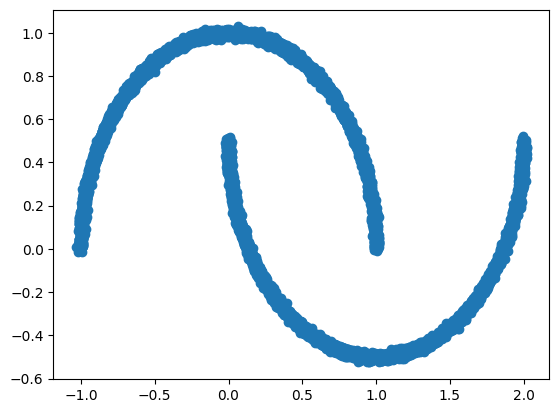

Step 0 | 20000: Loss - 5.67711067199707
Step 1000 | 20000: Loss - 0.27914953231811523
Step 2000 | 20000: Loss - 0.23273617029190063
Step 3000 | 20000: Loss - 0.22953668236732483
Step 4000 | 20000: Loss - 0.2650831341743469
Step 5000 | 20000: Loss - 0.22876015305519104
Step 6000 | 20000: Loss - 0.24341489374637604
Step 7000 | 20000: Loss - 0.21491080522537231
Step 8000 | 20000: Loss - 0.20199325680732727
Step 9000 | 20000: Loss - 0.31110167503356934
Step 10000 | 20000: Loss - 0.25505363941192627
Step 11000 | 20000: Loss - 0.2715790867805481
Step 12000 | 20000: Loss - 0.27407896518707275
Step 13000 | 20000: Loss - 0.27586179971694946
Step 14000 | 20000: Loss - 0.2323969006538391
Step 15000 | 20000: Loss - 0.24728547036647797
Step 16000 | 20000: Loss - 0.1511542797088623
Step 17000 | 20000: Loss - 0.25738561153411865
Step 18000 | 20000: Loss - 0.2890302836894989
Step 19000 | 20000: Loss - 0.2854210138320923


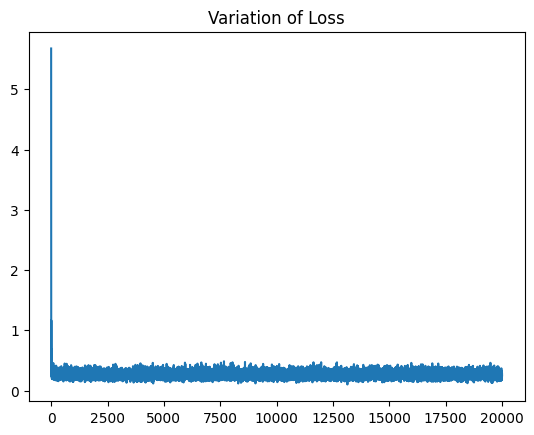

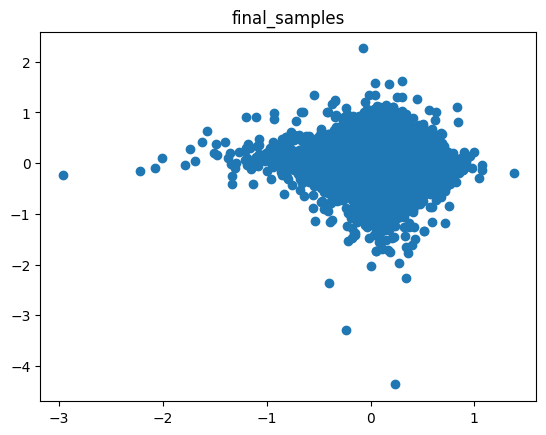

In [34]:
def main():
  batch_size = 64
  iterations = 20000
  hidden_dim = 128
  diffusion_steps = 100
  embed_dim = diffusion_steps
  key = 42
  num_samples = 10000
  eval_samples = 1000
  eval_interval = 1000
  batch_counter = 0

  dataset = make_dataset(num_samples)
  plt.figure()
  plt.scatter(dataset[:,0], dataset[:,1])
  plt.show()

  data_dim = dataset.shape[-1]
  diffusion = Diffusion(num_steps = diffusion_steps)
  model = MLP(hidden_dim = hidden_dim)
  rng = jax.random.PRNGKey(key)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(
      init_rng, model,
      input_shape = (batch_size, data_dim),
      time_shape = (batch_size,)
  )
  losses = []
  for step in range(iterations):
    min_size = batch_counter * batch_size
    max_size = (batch_counter + 1) * batch_size
    if max_size > num_samples:
      max_size = -1
      batch_counter = 0
    x = dataset[min_size:max_size]
    rng, sub_rng = jax.random.split(rng)
    t = jax.random.randint(sub_rng, (batch_size,), 0, diffusion_steps)
    noise = diffusion.sample(x, t, rng)
    state, loss = update_step(state, x, t, noise)
    losses.append(loss)
    if step % eval_interval == 0:
      print(f"Step {step} | {iterations}: Loss - {loss}")

  plt.figure()
  plt.plot([i for i in range(len(losses))], losses)
  plt.title("Variation of Loss")
  plt.show()

  samples = eval_sample(state.apply_fn, state.params, diffusion, num_samples, data_dim, diffusion_steps)
  plot_and_save(samples[-1,:,0], samples[-1,:,-1], "final_samples", "final_samples", show = True)

if __name__ == "__main__":
  main()

